In [4]:
# Reading data
import numpy as np
import pandas as pd

# Reading Parquet files
train_dataframe = pd.read_parquet(r'E:\Desktop\Text\Task1\train.parquet')
val_dataframe = pd.read_parquet(r'E:\Desktop\Text\Task1\validation.parquet')
test_dataframe = pd.read_parquet(r'E:\Desktop\Text\Task1\test.parquet')


In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.base import TransformerMixin
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Data Preprocessing
# Custom text cleaning and preprocessing class
class TextPreprocessor(TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))

    def clean_text(self, text):
        # Remove user tags and URLs
        text = re.sub(r'@\w+', '', text)
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'www\S+', '', text)
        # Remove HTML tags and special characters
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
        # Convert to lowercase
        text = text.lower()
        # Remove stopwords and perform lemmatization
        text = ' '.join([self.lemmatizer.lemmatize(word) for word in text.split() if word not in self.stop_words])
        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.clean_text(text) for text in X]


# Initialize the preprocessor
preprocessor = TextPreprocessor()


# Apply preprocessing
train_texts = preprocessor.transform(train_dataframe['text'])
val_texts = preprocessor.transform(val_dataframe['text'])
test_texts = preprocessor.transform(test_dataframe['text'])

# Tokenization and Padding
tokenizer = Tokenizer(num_words=8000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
val_sequences = tokenizer.texts_to_sequences(val_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

train_padded = pad_sequences(train_sequences, maxlen=26, padding='post', truncating='post')
val_padded = pad_sequences(val_sequences, maxlen=26, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=26, padding='post', truncating='post')

# Prepare labels
train_labels = tf.keras.utils.to_categorical(train_dataframe['label'])
val_labels = tf.keras.utils.to_categorical(val_dataframe['label'])
test_labels = tf.keras.utils.to_categorical(test_dataframe['label'])


In [6]:
# Transfer Learning
# Load the GloVe model
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import Constant

def load_glove_model(glove_file_path):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

glove_path = 'E:/Desktop/Text/Task1/glove.6B.100d.txt'  # Replace with actual path
embeddings_index = load_glove_model(glove_path)

# Create the word embedding matrix
embedding_dim = 100
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Build the model, modify the model structure, and use pre-trained word embeddings
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, embeddings_initializer=Constant(embedding_matrix), input_length=26, trainable=False),
    GRU(64),
    Dense(4, activation='softmax')
])


E:\Anaconda\envs\text_analytics\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [7]:
# # Build the model without using transfer learning
# import matplotlib.pyplot as plt
# from tensorflow.keras.callbacks import EarlyStopping

# # Build the model
# model = Sequential([
#     Embedding(input_dim=8000, output_dim=128, input_length=26),
#     GRU(64),  # Use a single GRU layer with the number of units reduced to 64
#     Dense(4, activation='softmax')  # Directly connected to the output layer
# ])


Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.4187 - loss: 1.3195 - val_accuracy: 0.4278 - val_loss: 1.2203
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4615 - loss: 1.1509 - val_accuracy: 0.5588 - val_loss: 1.0584
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5742 - loss: 1.0018 - val_accuracy: 0.5936 - val_loss: 1.0070
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6010 - loss: 0.9350 - val_accuracy: 0.5989 - val_loss: 1.0025
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6676 - loss: 0.8523 - val_accuracy: 0.5856 - val_loss: 0.9620
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6945 - loss: 0.8099 - val_accuracy: 0.6524 - val_loss: 0.9986
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7331 - loss: 0.7077 - val_accuracy: 0.6390 - val_loss: 0.8952
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7432 - loss: 0.6729 - val_accuracy: 0

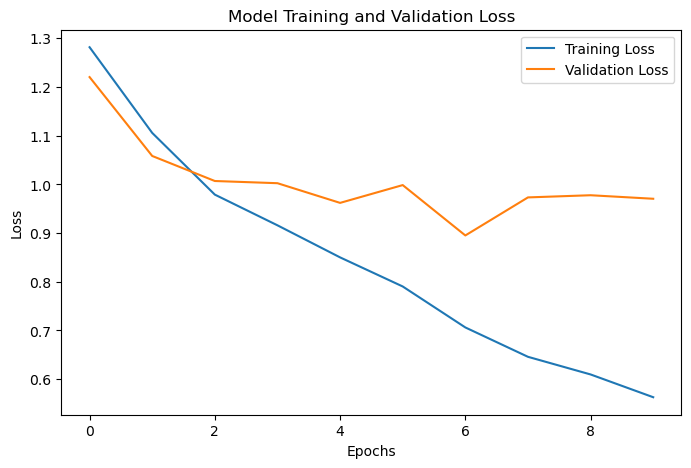

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Some examples of misclassified texts:

Original Text: @user Interesting choice of words... Are you confirming that governments fund #terrorism? Bit of an open door, but still...
Processed Text: interesting choice word confirming government fund terrorism bit open door still
Predicted Label: 3, Actual Label: 0

Original Text: @user @user #cmbyn does screen  August 4 &amp; 6 at #miff
Processed Text: cmbyn screen august amp miff
Predicted Label: 1, Actual Label: 3

Original Text: That moment when people say you don't need medicine, it's mind over matter. You need to stop doing that. #bipolar
Processed Text: moment people say dont need medicine mind matter need stop bipolar
Predicted Label: 3, Actual Label: 0

Original Text: @user @user Americans do not spank their children, and they are a God fearing people who knows the biggest sin is hypocrisy.
Processed Text: american spank child god fearing people know biggest sin hypocrisy
Predicted Label: 0, Ac

In [8]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Configure early stopping strategy
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='min', restore_best_weights=True)

# Train the model, add early stopping strategy to callback functions
history = model.fit(train_padded, train_labels, epochs=10, validation_data=(val_padded, val_labels), callbacks=[early_stopping])

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_padded, test_labels)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

# Plot training loss and validation loss
plt.figure(figsize=(8, 5))  # Set the size of the figure
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('E:/Desktop/Text/Task1/loss.pdf', format='pdf')
plt.show()


# Prediction and evaluation
test_predictions = model.predict(test_padded)
test_predictions_labels = np.argmax(test_predictions, axis=1)
misclassified_indices = np.where(test_predictions_labels != np.argmax(test_labels, axis=1))[0]

print("Some examples of misclassified texts:")
print()
for index in misclassified_indices[:10]:  # Display the first ten misclassified samples
    original_text = test_dataframe['text'].iloc[index]  # Retrieve the original text
    processed_text = preprocessor.transform([original_text])[0]  # Process the original text

    print(f"Original Text: {original_text}")
    print(f"Processed Text: {processed_text}")
    print(f"Predicted Label: {test_predictions_labels[index]}, Actual Label: {np.argmax(test_labels[index], axis=0)}\n")


In [9]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from collections import Counter

# train_dataframe = pd.read_parquet(r'E:\Desktop\Text\Task1\train.parquet')

# # Extract sentences and calculate their lengths to find the optimal truncation number
# sentence_lengths = [len(s.split()) for s in train_dataframe['text']]

# # Plot the distribution of sentence lengths
# plt.hist(sentence_lengths, bins=30)
# plt.title('Sentence Length Distribution')
# plt.xlabel('Sentence Length')
# plt.ylabel('Number of Sentences')
# plt.show()

# # Display some statistics about sentence lengths
# print("Mean Length:", np.mean(sentence_lengths))
# print("Median Length:", np.median(sentence_lengths))
# print("95th Percentile:", np.percentile(sentence_lengths, 95))

# # Assess vocabulary richness
# all_words = [word for text in train_dataframe['text'] for word in text.split()]
# word_counts = Counter(all_words)
# print("Unique words:", len(word_counts))

# # Set vocabulary size based on word frequency
# total_words = sum(word_counts.values())
# cumulative = 0
# sorted_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

# for word, freq in sorted_words:
#     cumulative += freq
#     if cumulative / total_words > 0.90:
#         max_vocab_size = sorted_words.index((word, freq)) + 1
#         print("Vocabulary size to cover 90% of words:", max_vocab_size)
#         break
